In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals
import os
from operator import itemgetter

import matplotlib.pylab as plt
# %matplotlib widget
%matplotlib inline

import numpy as np
import tensorflow as tf
tf.random.set_seed(99)
from tensorflow.keras import layers, models
from keras.callbacks import EarlyStopping
import keras
import keras_metrics
from keras.wrappers.scikit_learn import KerasClassifier

from sklearn.metrics import roc_curve,roc_auc_score
from sklearn.metrics import auc


from PIL import Image as img
import pandas as pd

Using TensorFlow backend.


In [2]:
IMG_SHAPE = (39, 39)

### LOAD DATA

In [3]:
dataset_root = './dataset/02-crop_img/'

In [4]:
image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255,
                                                                  validation_split=0.17)
train_data = image_generator.flow_from_directory(dataset_root, target_size=IMG_SHAPE,
                                                 subset='training')
validation_data = image_generator.flow_from_directory(dataset_root, target_size=IMG_SHAPE,
                                                      subset='validation')

for image_batch, label_batch in validation_data:
    print(f'Image batch shape: {image_batch.shape}')
    print(f'Label batch shape: {label_batch.shape}')
    break
    
class_names = sorted(validation_data.class_indices.items(), key=itemgetter(1))
class_names = np.array([key.title() for key, value in class_names])
print(f'Classes: {class_names}')

Found 46483 images belonging to 2 classes.
Found 9519 images belonging to 2 classes.
Image batch shape: (32, 39, 39, 3)
Label batch shape: (32, 2)
Classes: ['Clickable' 'Non-Clickable']


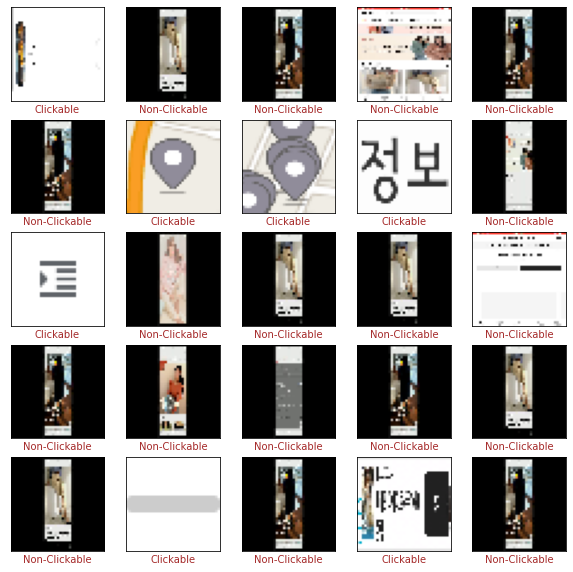

In [5]:
predicted_id = np.argmax(label_batch, axis=-1)
predicted_label_batch = class_names[predicted_id]

fig1 = plt.figure(figsize=(10, 10))
for i in range(25):
    ax = fig1.add_subplot(5, 5, i+1)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.grid(False)
    ax.imshow(image_batch[i])
    ax.set_xlabel(predicted_label_batch[i], color='brown')

In [6]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=IMG_SHAPE + (3, )))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(len(validation_data.class_indices)))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 37, 37, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 18, 18, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
flatten (Flatten)            (None, 16384)             0         
_________________________________________________________________
dense (Dense)                (None, 64)                1048640   
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 130       
Total params: 1,068,162
Trainable params: 1,068,162
Non-trainable params: 0
______________________________________________

In [7]:
checkpoint_path = "./dataset/03-models/training_1/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# 체크포인트 콜백 만들기
cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)


In [8]:
base_learning_rate = 0.01
model.compile(
             optimizer = tf.keras.optimizers.SGD(learning_rate=base_learning_rate),
             loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
             metrics=['accuracy', keras.metrics.Precision(), keras.metrics.Recall()])

class CollectBatchStats(tf.keras.callbacks.Callback):
    def __init__(self):
        self.batch_losses = []
        self.batch_val_losses = []
        
        self.batch_acc = []
        self.batch_val_acc = []
        
        self.batch_precision = []
        self.batch_val_precision = []
        
        self.batch_recall = []
        self.batch_val_recall = []
    
    def on_epoch_end(self, epoch, logs=None):
        self.batch_losses.append(logs['loss'])
        self.batch_acc.append(logs['accuracy'])
        
        self.batch_val_losses.append(logs['val_loss'])
        self.batch_val_acc.append(logs['val_accuracy'])
        
        self.batch_precision.append(logs['precision_1'])
        self.batch_val_precision.append(logs['val_precision_1'])
        
        self.batch_recall.append(logs['recall_1'])
        self.batch_val_recall.append(logs['val_recall_1'])
        self.model.reset_metrics()

In [9]:
steps_per_epoch = np.ceil(train_data.samples/train_data.batch_size) # train all dataset per epoch
initial_epoch = 20
batch_stats_callback = CollectBatchStats()
earlystop_callback = EarlyStopping(monitor='val_accuracy', min_delta=0.0001, patience=3)

history = model.fit_generator(train_data,
                              epochs=initial_epoch,
                              steps_per_epoch=steps_per_epoch,
                              validation_data=validation_data,
                              callbacks=[batch_stats_callback, earlystop_callback, cp_callback])

Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 1453.0 steps, validate for 298 steps
Epoch 1/20
1452/1453 [============================>.] - ETA: 0s - loss: 0.1941 - accuracy: 0.9246 - precision_1: 0.9155 - recall_1: 0.7653
Epoch 00001: saving model to ./dataset/03-models/training_1/cp.ckpt
1453/1453 [==============================] - 576s 396ms/step - loss: 0.1941 - accuracy: 0.9246 - precision_1: 0.9155 - recall_1: 0.7653 - val_loss: 0.0447 - val_accuracy: 0.9817 - val_precision_1: 0.9588 - val_recall_1: 0.8668
Epoch 2/20
1452/1453 [============================>.] - ETA: 0s - loss: 0.0766 - accuracy: 0.9758 - precision_1: 0.9679 - recall_1: 0.8972
Epoch 00002: saving model to ./dataset/03-models/training_1/cp.ckpt
1453/1453 [==============================] - 557s 383ms/step - loss: 0.0765 - accuracy: 0.9759 - precision_1: 0.9679 - recall_1: 0.8972 - val_loss: 0.0372 - val_accuracy: 0.9878 - val_pr

In [10]:
model.save('./dataset/03-models/model/my_model_v2.h5')

In [11]:
test_img = '/home/kimsoohyun/Downloads/Screenshot_20200418-220702_Abyssrium Pole.jpg'
img = tensorflow.read_file(test_img)

NameError: name 'tensorflow' is not defined

Text(0.5, 0, 'epoch')

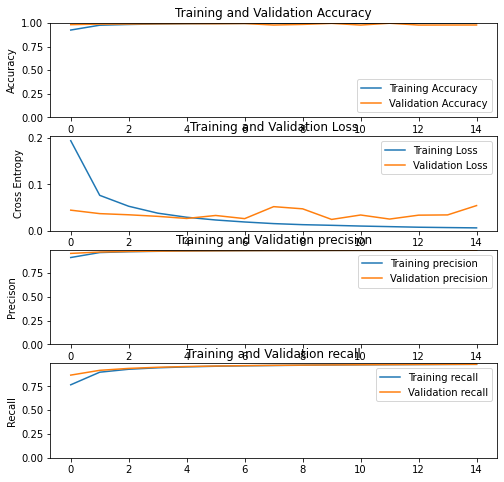

In [12]:
# Draw learning curves chart
acc = batch_stats_callback.batch_acc
val_acc = batch_stats_callback.batch_val_acc
loss = batch_stats_callback.batch_losses
val_loss = batch_stats_callback.batch_val_losses

precision = batch_stats_callback.batch_precision
val_precision = batch_stats_callback.batch_val_precision
recall = batch_stats_callback.batch_recall
val_recall = batch_stats_callback.batch_val_recall

fig2 = plt.figure(figsize=(8, 8))
ax1 = fig2.add_subplot(4, 1, 1)
ax1.plot(acc, label='Training Accuracy')
ax1.plot(val_acc, label='Validation Accuracy')
ax1.legend(loc='lower right')
ax1.set_ylabel('Accuracy')
ax1.set_ylim([0, 1])
ax1.set_title('Training and Validation Accuracy')

ax2 = fig2.add_subplot(4, 1, 2)
ax2.plot(loss, label='Training Loss')
ax2.plot(val_loss, label='Validation Loss')
ax2.legend(loc='upper right')
ax2.set_ylabel('Cross Entropy')
ax2.set_ylim([0,max(ax2.get_ylim())])
ax2.set_title('Training and Validation Loss')


ax3 = fig2.add_subplot(4, 1, 3)
ax3.plot(precision, label='Training precision')
ax3.plot(val_precision, label='Validation precision')
ax3.legend(loc='upper right')
ax3.set_ylabel('Precison')
ax3.set_ylim([0,max(ax3.get_ylim())])
ax3.set_title('Training and Validation precision')




ax4 = fig2.add_subplot(4, 1, 4)
ax4.plot(recall, label='Training recall')
ax4.plot(val_recall, label='Validation recall')
ax4.legend(loc='upper right')
ax4.set_ylabel('Recall')
ax4.set_ylim([0,max(ax4.get_ylim())])
ax4.set_title('Training and Validation recall')



ax2.set_xlabel('epoch')

In [ ]:
history.history['']

In [ ]:
#predict curve
holdout_gen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255)
holdout = holdout_gen.flow_from_directory(dataset_root, target_size=IMG_SHAPE)
model_eval = model.predict_generator(holdout, 
                                 use_multiprocessing=True,
                                 steps=validation_data.n)


In [ ]:
pred = pd.DataFrame(model_eval, columns = holdout.class_indices.keys())
pred.head(1)


In [ ]:
pred.head(10)


In [ ]:
def get_truths(df, class_label, index):
    y_truth = df.iloc[index] == class_label
    return y_truth.astype(int).values, df[class_label].values

In [ ]:
# Compute ROC curve and ROC area for each class
n_classes = len(holdout.class_indices)
classes = holdout.class_indices.keys()
lw=2
fpr = dict()
tpr = dict()
roc_auc = dict()
for k,i in holdout.class_indices.items():
    print(k, i)
    t, p = get_truths(pred, k, i)
    print(t, p)
    fpr[i], tpr[i], _ = roc_curve(t, p)
    roc_auc[i] = auc(fpr[i], tpr[i])

#############################################################
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])
mean_tpr /= n_classes

fpr['micro'], tpr['micro'], _ = roc_curve()
roc_auc['micro'] = auc(fpr['micro'], tpr['micro'])

fpr['macro'] = all_fpr
tpr['macro'] = mean_fpr
roc_auc['macro'] = auc(fpr['macro'], tpr['macro'])


plt.plot(fpr['micro'], tpr['micro'],
         label='ROC curve (area = %0.2f)' % roc_auc['micro'],
         linewidth=2)
plt.plot(fpr['macro'], tpr['macro'],
         label='ROC curve (area = %0.2f)' % roc_auc['macro'],
         linewidth=2)


for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'
                                   ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1],'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc='lower right')
plt.show()
##############################################################


#all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
#mean_tpr = np.zeros_like(all_fpr)





# Then interpolate all ROC curves at these points
#mean_tpr = np.zeros_like(all_fpr)
#for i in range(n_classes):
#    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# average it and compute AUC
#mean_tpr /= n_classes

#fpr["overall"] = all_fpr
#tpr["overall"] = mean_tpr
#roc_auc["overall"] = metrics.auc(fpr["overall"], tpr["overall"]

In [ ]:
print_auc = (lambda x,v: print('{v} AUC: {x:.6f}'.format(v=v, x=x)))
for k,v in holdout.class_indices.items():
    print_auc(roc_auc[v], k)
print_auc(roc_auc['overall'], "Overall")

In [ ]:
 random.shuffle(clickable_click_list)
random.shuffle(non_clickable_click_list)
print(len(clickable_click_list))
print(len(non_clickable_click_list))

In [ ]:
train_click = clickable_click_list[0:6514]
test_click = clickable_click_list[6516:8627]
valid_click = clickable_click_list[8627:]

In [ ]:
x_train = []
for i in tqdm(clickable_click_list):
    temp = img.open(i).resize((64, 64))
    temp = temp.convert('L')
    x_train.append((np.array(temp) - np.mean(temp)) / np.std(temp))
    x_train.append((np.array(temp.rotate(90)) - np.mean(temp)) / np.std(temp))
    x_train.append((np.array(temp.rotate(180)) - np.mean(temp)) / np.std(temp))
    x_train.append((np.array(temp.rotate(270)) - np.mean(temp)) / np.std(temp))
    
y_train = np.tile(1, len(clickable_click_list)*4)
print("dog's images loading is done")   